In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import cv2
import os 
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image
import random
import matplotlib.image as mpimg
from imutils import paths
import sys
import operator

In [3]:
!pip install rich
!pip install hydra-core
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 4.1 MB/s 
     |████████████████████████████████| 51 kB 7.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 151 kB 4.2 MB/s 
     |████████████████████████████████| 117 kB 52.6 MB/s 
     |████████████████████████████████| 79 kB 8.4 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=5408a859a77831cdedfd82c48e0dffdd52365d2793e503ac91ee1eb75b8f1fe5
  Stored in directory: /root/.cache/pip/wheels/8b/8d/53/2af8772d9aec614e3fc65e53d4a993ad73c61daa8bbd85a873
Successfully built antlr4-python3-runtime


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 705 kB 4.2 MB/s 
     |████████████████████████████████| 5.9 MB 48.3 MB/s 
     |████████████████████████████████| 419 kB 49.7 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.


In [4]:
sys.path.insert(0, "/content/drive/MyDrive/Github_Repos/historia_ml_handwritten_text_line_segmentation")
sys.path.insert(1, "/content/drive/MyDrive/Github_Repos/historia_ml_handwritten_text_line_segmentation/src/utils")

In [5]:
import pytorch_lightning as pl
from src.utils.display_image_from_path import img_show
from src.utils.display_image_from_array import img_show_from_arr

In [39]:
img = cv2.imread("/content/drive/MyDrive/Images/image.png")
img_mask = cv2.imread("/content/drive/MyDrive/output/test_page_predicted_masks/osmanlica_test_mask.png")

In [123]:
h, w, d = img_mask.shape
binary_mask = img_mask.copy()
binary_mask[109][150]

array([255, 255, 255], dtype=uint8)

In [41]:
binary_mask[109][150]

array([255, 255, 255], dtype=uint8)

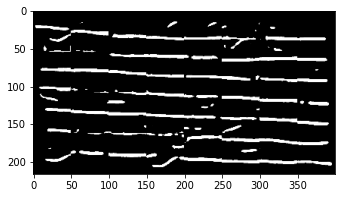

In [42]:
img_show_from_arr(img_mask)

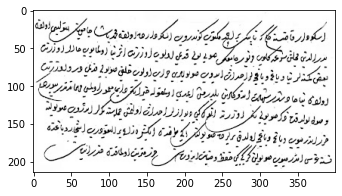

In [165]:
img_show_from_arr(img)

In [167]:
img.shape

(214, 400, 3)

In [166]:
img_show_from_arr(img * img_mask)

ValueError: ignored

In [47]:
h, w, d = binary_mask.shape

In [50]:
for i in range(h):
  for j in range(w):
    for k in range(d):
      if binary_mask[i][j][k] > 128:
        binary_mask[i][j][k] = 255
      else:
        binary_mask[i][j][k] = 0

In [ ]:
img_mask[40:50, 30:40, :]

In [ ]:
binary_mask[40:50, 30:40, :]

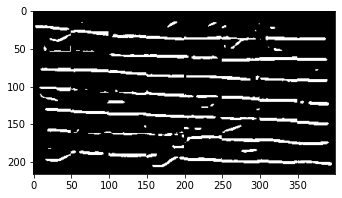

In [53]:
img_show_from_arr(binary_mask)

In [54]:
import collections

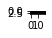

In [89]:
window = binary_mask[1:5, 0:20, :]
img_show_from_arr(window)

In [90]:
type(window)

numpy.ndarray

In [91]:
unique, counts = np.unique(window, return_counts=True)
x = np.asarray((unique, counts)).T
x

array([[  0, 240]])

In [92]:
len(x)

1

In [93]:
x[0][1]

240

In [75]:
x[1][1]

300

In [100]:
def frequency_of_ones(window):
  unique, counts = np.unique(window, return_counts=True)
  x = np.asarray((unique, counts)).T

  if len(x) == 1:
    if x[0][0] == 0:
      return 0
    else:
      return x[0][1]
  else:
    return x[1][1]


In [79]:
frequency_of_ones(window)

300

In [142]:
line_pixels = []
for i in range(2, h):
  for j in range(10, w):
      window = binary_mask[i-2:i+2, j-10:j+10, :]
      freq_ones = frequency_of_ones(window)
      if freq_ones > 20:
        line_pixels.append((i, j))

In [143]:
len(line_pixels)

3427

In [131]:
216*400*3

259200

In [127]:
line_pixels[:10]

[(29, 98),
 (29, 99),
 (29, 100),
 (29, 101),
 (34, 133),
 (34, 134),
 (34, 135),
 (35, 122),
 (35, 123),
 (36, 213)]

In [128]:
window = binary_mask[27:31, 88:108, :]
frequency_of_ones(window)

108

In [130]:
window = binary_mask[27:31, 89:109, :]
frequency_of_ones(window)

99

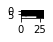

In [129]:
img_show_from_arr(binary_mask[20:30, 80:110, :])

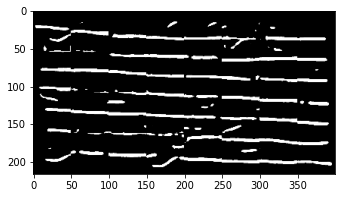

In [124]:
img_show_from_arr(binary_mask)

In [144]:
line_mask = np.zeros(img.shape)
for coord in line_pixels:
  line_mask[coord[0]][coord[1]][0] = 255
  line_mask[coord[0]][coord[1]][1] = 255
  line_mask[coord[0]][coord[1]][2] = 255

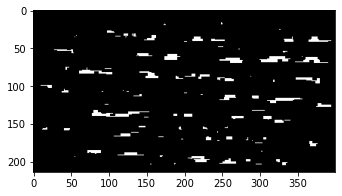

In [145]:
img_show_from_arr(line_mask)

In [159]:
def next_neighbor_as_zero(height, width, mask):

  pixels_having_0_as_neighbor = []

  for i in range(1, height-1):
    for j in range(1, width-1):
      if mask[i][j][0] == 255:
        if mask[i-1][j][0] == 0: # downstairs neighbor
          pixels_having_0_as_neighbor.append((i, j))
        elif mask[i][j-1][0] == 0: # left neighbor
          pixels_having_0_as_neighbor.append((i, j))
        elif mask[i+1][j][0] == 0: # upstairs neighbor
          pixels_having_0_as_neighbor.append((i, j))
        elif mask[i][j+1][0] == 0: # right neighbor
          pixels_having_0_as_neighbor.append((i, j))
  return pixels_having_0_as_neighbor

In [160]:
for i in range(h):
  for j in range(w):
    for k in range(d):
      if binary_mask[i][j][k] > 128:
        binary_mask[i][j][k] = 255
      else:
        binary_mask[i][j][k] = 0

In [161]:
h, w, d = binary_mask.shape
neighbor0_pixels = next_neighbor_as_zero(h, w, binary_mask)
neighbor_mask = np.zeros(binary_mask.shape)

In [162]:
len(neighbor0_pixels)

5441

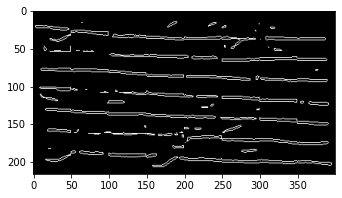

In [163]:
for coord in neighbor0_pixels:
  neighbor_mask[coord[0]][coord[1]][0] = 255
  neighbor_mask[coord[0]][coord[1]][1] = 255
  neighbor_mask[coord[0]][coord[1]][2] = 255

img_show_from_arr(neighbor_mask)

In [164]:
x = frequency_of_ones(neighbor_mask)
x

16323.0